In [1]:
import shap
import xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

Import the shear wall database

In [2]:
data1 = pd.read_excel('Shear_Wall_Database.xlsx', sheet_name='Database')
data1.head()

,Unnamed: 0,Author,Specimen,FailureMode,M/Vlw,lw/tw,"ρvwFy,vw/fc","ρhwFy,hw/fc","ρvcFy,vc/fc","ρhcFy,hc/fc",P/fcAg,Section,Ab/Ag
0,1,Lefas et al. (1990a),SW11,1,1.1,10.714286,0.268879,0.136711,0.348231,0.149140,0.000000,R,0.0
1,2,Lefas et al. (1990a),SW12,1,1.1,10.714286,0.262358,0.133396,0.339785,0.145522,0.102168,R,0.0
2,3,Lefas et al. (1990a),SW13,1,1.1,10.714286,0.346364,0.176108,0.448584,0.192118,0.208187,R,0.0
3,4,Lefas et al. (1990a),SW14,1,1.1,10.714286,0.334023,0.169834,0.432601,0.185273,0.000000,R,0.0
4,5,Lefas et al. (1990a),SW15,1,1.1,10.714286,0.324766,0.165127,0.420612,0.180139,0.101727,R,0.0


In [3]:
len(data1)

393

In [4]:
data=data1.loc[:, 'FailureMode':'Ab/Ag']
data.head()

,FailureMode,M/Vlw,lw/tw,"ρvwFy,vw/fc","ρhwFy,hw/fc","ρvcFy,vc/fc","ρhcFy,hc/fc",P/fcAg,Section,Ab/Ag
0,1,1.1,10.714286,0.268879,0.136711,0.348231,0.149140,0.000000,R,0.0
1,1,1.1,10.714286,0.262358,0.133396,0.339785,0.145522,0.102168,R,0.0
2,1,1.1,10.714286,0.346364,0.176108,0.448584,0.192118,0.208187,R,0.0
3,1,1.1,10.714286,0.334023,0.169834,0.432601,0.185273,0.000000,R,0.0
4,1,1.1,10.714286,0.324766,0.165127,0.420612,0.180139,0.101727,R,0.0


##### Convert the String in Section to numerical values

In [5]:
data_mod_lc = data.copy()
data_mod_lc['Section'] = data_mod_lc['Section'].astype('category')
#print(cat_bird_lc.dtypes)
data_mod_lc['Section'] = data_mod_lc['Section'].cat.codes
data['Section'] = data_mod_lc['Section']
data.head()

,FailureMode,M/Vlw,lw/tw,"ρvwFy,vw/fc","ρhwFy,hw/fc","ρvcFy,vc/fc","ρhcFy,hc/fc",P/fcAg,Section,Ab/Ag
0,1,1.1,10.714286,0.268879,0.136711,0.348231,0.149140,0.000000,2,0.0
1,1,1.1,10.714286,0.262358,0.133396,0.339785,0.145522,0.102168,2,0.0
2,1,1.1,10.714286,0.346364,0.176108,0.448584,0.192118,0.208187,2,0.0
3,1,1.1,10.714286,0.334023,0.169834,0.432601,0.185273,0.000000,2,0.0
4,1,1.1,10.714286,0.324766,0.165127,0.420612,0.180139,0.101727,2,0.0


In [6]:
# Generate X and y data
X = data.loc[:, data.columns != 'FailureMode']
y=data['FailureMode']
#X.head()

In [7]:
# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
RF1 = RandomForestClassifier(n_estimators= 1600, min_samples_split= 5, min_samples_leaf= 1, max_features= 'sqrt', max_depth=70, bootstrap= 'False')
RF1.fit(X_train, y_train)
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(RF1.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(RF1.score(X_test, y_test)))

Accuracy of RF classifier on training set: 0.99
Accuracy of RF classifier on test set: 0.86


In [9]:
# Confusion matrix fr training set
y_pred_train = RF1.predict(X_train)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_train, y_pred_train)
print(confusion_matrix)

[[106   0   0   0]
 [  0  65   1   0]
 [  0   0  84   0]
 [  0   1   1  17]]


In [10]:
# Confusion matrix fr test set
y_pred_test = RF1.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_test)
print(confusion_matrix)

[[42  3  0  1]
 [ 5 21  4  0]
 [ 2  2 34  0]
 [ 0  0  0  4]]


### Explain the SHAP model's predictions on the entire dataset

In [11]:
X_shap = scaler.transform(X)

In [12]:
X_shap = pd.DataFrame(X_shap, columns = X.columns)

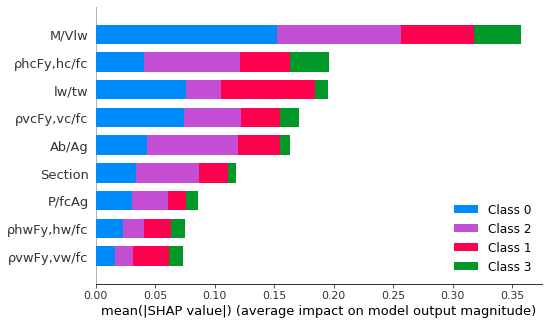

In [13]:
explainer = shap.TreeExplainer(RF1)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap)

##### The bar plot shows the importance lists of the most significant variables for the failure modes in descending order

## Individual value plot

shap_value[0] corresponds to class zero, shap_value[1] corresponds to class one,...

Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

In [14]:
# Single value explainer
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_shap.iloc[0,:])

##### Thr selected column corresponds to the flexural mode of failure. The predicted value [0.68] is higher than the base value [0.24].
##### P/fcAg zero and M/Vlw of 0.2208 push the prediction down

### Entire value plot

In [15]:
shap.force_plot(explainer.expected_value[1], shap_values[0][:len(X_shap),:], X_shap.iloc[:len(X_shap),:])

## Importance plots for various modes of failure

##### In the following plots, the horizontal location shows whether the effect of that value is associated with a higher or lower prediction.

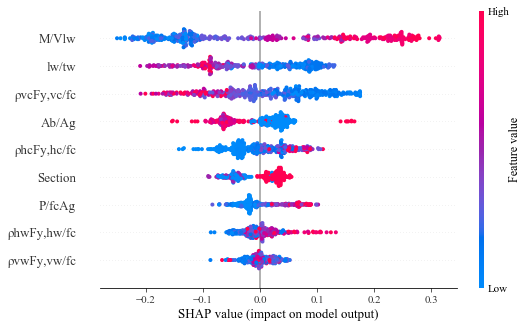

In [16]:
# Importance of Shap value for Class 0 prediction
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
shap.summary_plot(shap_values[0], X_shap,  show=False)
#plt.savefig('ShearWall_flexure.eps',format='eps', dpi=1000)


##### Class 0 corresponds to flexure mode of failure. The plot shows that the impact of high value of M/Vlw on Faiure mode 'flexure; prediction is positive. In other words, if M/Vlw is high, the model would like to predict flexure mode of failure

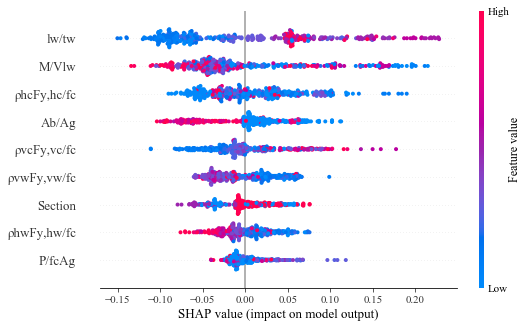

In [17]:
# Importance of Shap value for Class1 (Flexure shear)
shap.summary_plot(shap_values[1], X_shap,  show=False)
#plt.savefig('ShearWall_flexure_shear.eps',format='eps', dpi=1000)

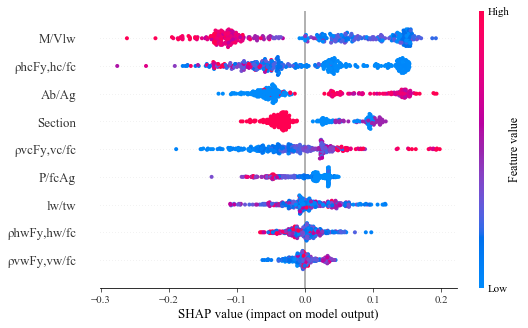

In [18]:
# Importance of Shap value for Class2 (Shear)
shap.summary_plot(shap_values[2], X_shap,  show=False)
#plt.savefig('ShearWall_shear.eps',format='eps', dpi=1000)

#### Class 2 corresponds to shear mode of failure. The plot shows that if M/Vlw is low, the model would predict shear mode of failure

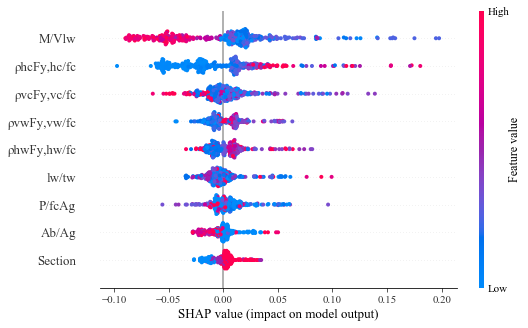

In [19]:
# Importance of Shap value for Class3 (Sliding)
shap.summary_plot(shap_values[3], X_shap,  show=False)
#plt.savefig('ShearWall_sliding.eps',format='eps', dpi=1000)

## Dependance plot

SHAP dependence plots shows the marginal effect of a feature  on the expected prediction. The dependence plot helps to see the underlying relation  (e.g., linear, curve, complex,..) of the feature on the outcome. The most dependant variable to the selected variable is shown as a bar on the right side of the axis.

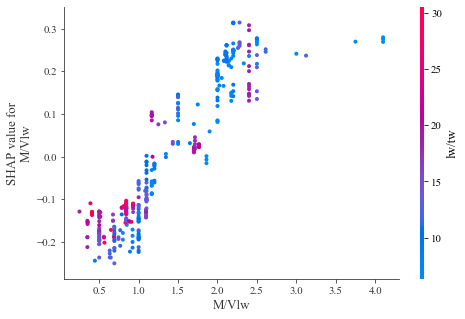

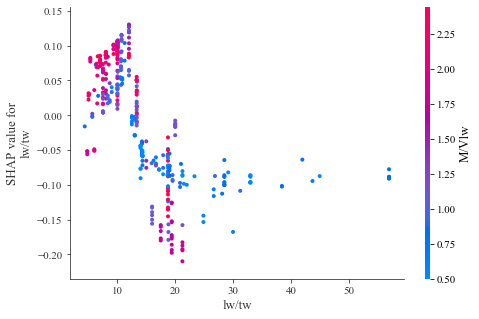

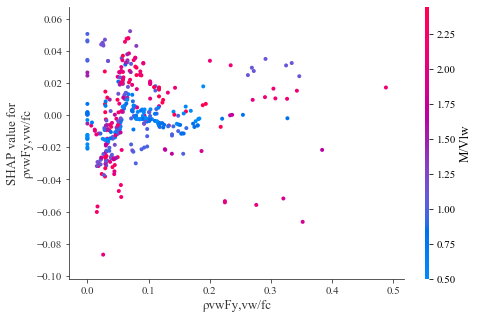

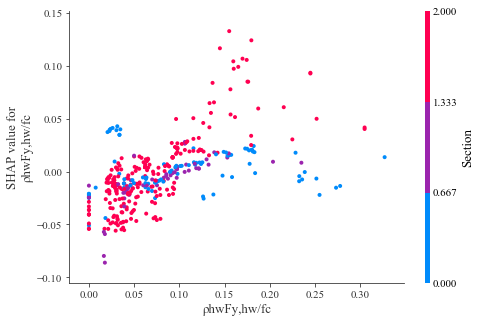

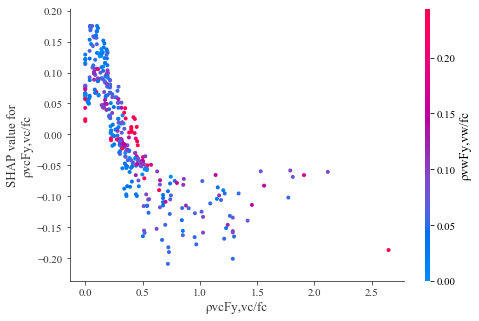

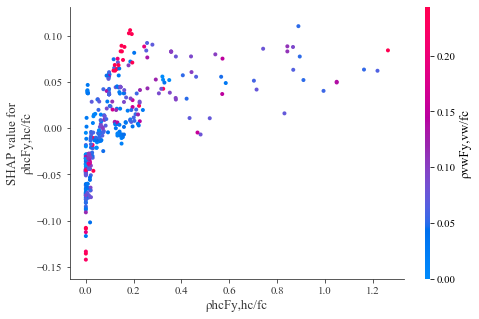

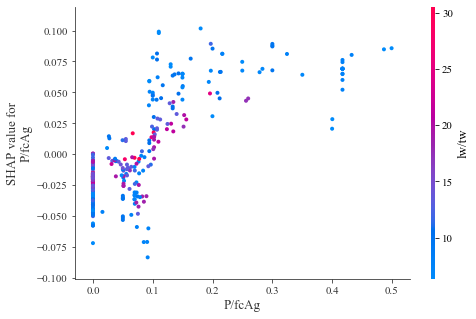

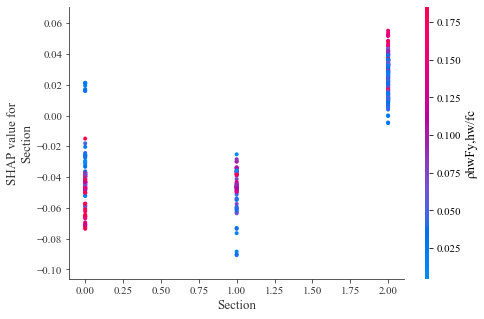

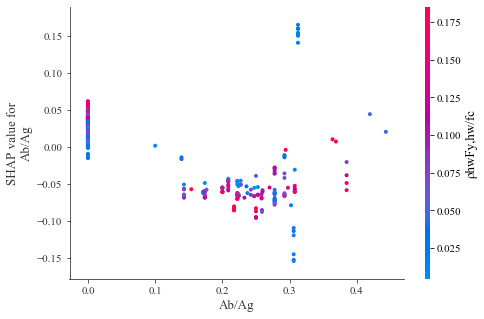

In [20]:
# Plot the dependance plot for class 0
n=1
for name in X_shap.columns:
    shap.dependence_plot(name, shap_values[0], X, display_features=X_shap, show=False )
    
#     plt.savefig("Graph_Shear_wall" + str(n) +".eps", format="EPS")
#     n=n+1



In [21]:
pwd

'C:\\Users\\sujit\\Shap_value\\Shap_codes_columns_ShearWalls'